tb - 7/8/2022 - Generalizing the data generator for sparse linear regression using stochastic gradient descent. The goal is to select the terms found in [093] using the entire dataset. One of the first steps will be to compare features selected when training on both datasets at once compared to individual (-4K) or (+4K) climates.

# Imports and Initialization

## Imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures

from cbrain.cam_constants import *
from cbrain.climate_invariant import *
from cbrain.equation_discovery import *
from cbrain.preprocessing.convert_dataset_20191113 import compute_LHF_nsDELQ
from cbrain.climate_invariant_utils import *
from scipy.integrate import cumtrapz,trapz
from scipy import interpolate,misc

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
import xarray as xr

/nfspool-0/home/tbeucler/CBRAIN-CAM/notebooks/tbeucler_devlog


In [2]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

## Load data

In [3]:
path_data = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/'
path_array = {}
climate_str = ['cold','hot','both']
set_str = ['train','valid','test']
test_clim_str = ['cold','hot','both','medium']
path_array['cold'] = [path_data+'2021_03_18_O3_TRAIN_M4K_shuffle.nc',
                      path_data+'2021_03_18_O3_VALID_M4K.nc',
                      path_data+'2021_03_18_O3_TEST_M4K.nc']
path_array['hot'] = [path_data+'2021_03_18_O3_TRAIN_P4K_shuffle.nc',
                     path_data+'2021_03_18_O3_VALID_P4K.nc',
                     path_data+'2021_03_18_O3_TEST_P4K.nc']
path_array['both'] = [path_data+'2022_04_18_TRAIN_M4K_P4K_shuffle.nc',
                      path_data+'2022_04_18_VALID_M4K_P4K.nc',
                      path_data+'2022_04_18_TEST_M4K_P4K.nc']
path_array['medium'] = [path_data+'2021_01_24_O3_TRAIN_shuffle.nc',
                        path_data+'2021_01_24_O3_VALID.nc',
                        path_data+'2021_01_24_O3_TEST.nc']
path_input_norm = path_data + '2021_01_24_NORM_O3_small.nc'
path_norm_RH = path_data + '2021_02_01_NORM_O3_RH_small.nc'
path_norm_BMSE = path_data + '2021_06_16_NORM_BMSE_small.nc'
path_norm_LHF_nsDELQ = path_data + '2021_02_01_NORM_O3_LHF_nsDELQ_small.nc'
in_vars = ['QBP','TBP','PS','SOLIN','SHFLX','LHFLX'] # We take the large-scale climate state as inputs
out_vars = ['PHQ','TPHYSTND','QRL','QRS'] # and we output the response of clouds/storms to these climate conditions
scale_dict = pickle.load(open(path_data+'009_Wm2_scaling.pkl','rb'))

In [4]:
path_RH_B_train = path_data+'2022_07_08_B_RH_TRAIN_both.nc'
path_RH_B_test = path_data+'2022_06_26_B_RH_both.nc'

In [5]:
climates = ['m4K','ref','p4K']
path_append = ['2021_03_18_O3_TEST_M4K.nc','2021_01_24_O3_TEST.nc','2021_03_18_O3_TEST_P4K.nc']
path_RH_B_append = ['2022_06_27_B_RH_TEST_m4K.nc','2022_06_27_B_RH_TEST_ref.nc','2022_06_27_B_RH_TEST_p4K.nc']
path_LHF_nsDELQ = '2022_06_29_LHF_nsDELQ.nc'
path_LHF_nsDELQ_train = '2022_07_08_LHF_nsDELQ_TRAIN_both.nc'

In [6]:
LHF_nsDELQ_train = xr.open_dataset(path_data+path_LHF_nsDELQ_train)
LHF_nsDELQ_test = xr.open_dataset(path_data+path_LHF_nsDELQ)

In [7]:
train_both = xr.open_dataset(path_array['both'][0])
train_both_RH_B = xr.open_dataset(path_RH_B_train)

In [8]:
test_sets = {}; test_sets_RHB = {}; 
LHFname = ['LHFns_cold','LHFns_med','LHFns_hot']

In [9]:
for iclim,clim in enumerate(climates):
    test_sets[clim] = xr.open_dataset(path_data+path_append[iclim])
    test_sets_RHB[clim] = xr.open_dataset(path_data+path_RH_B_append[iclim])

In [10]:
ind_input = np.concatenate((np.arange(0,60),np.arange(90,94)))
ind_output = np.arange(94,94+60)

In [11]:
xt = {}; yt = {}; xRHt= {}; xBt = {}; xLHFnst = {};

In [12]:
name_RH = ['RH_test_cold','RH_test_med','RH_test_hot']
name_B = ['B_test_cold','B_test_med','B_test_hot']

In [13]:
x = train_both['vars'][:,ind_input]
xRH = train_both_RH_B['RH_train']
xB = train_both_RH_B['B_train']
xLHFns = LHF_nsDELQ_train['LHFns']
y = train_both['vars'][:,ind_output]
for iclim,clim in enumerate(climates):
    xt[clim] = test_sets[clim]['vars'][:,ind_input]
    xRHt[clim] = test_sets_RHB[clim][name_RH[iclim]]
    xBt[clim] = test_sets_RHB[clim][name_B[iclim]]
    xLHFnst[clim] = LHF_nsDELQ_test[LHFname[iclim]]
    yt[clim] = test_sets[clim]['vars'][:,ind_output]

In [14]:
Model_Types = ['localBF','localCI','BF','CI']
N_subsample = 5
N_degree = 4
Nsample = 3000

In [15]:
KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))

# SFS+Polynomial fit optimized using least-squared error

In [16]:
min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

In [17]:
dict_Q = {}; dict_T = {};

In [18]:
save_name = path_data+'2022_07_22_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

tmp = pickle.load(open(save_name,'rb'))

Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}
for keys in combin_keys:
    Norm['mean'][keys] = tmp['MEAN'][keys]
    Norm['min'][keys] = tmp['MIN'][keys]
    Norm['max'][keys] = tmp['MAX'][keys]
    Norm['std'][keys] = tmp['STD'][keys]    

## Third attempt, this time loading both the cold and the warm parts of the dataset and not limiting the index range to only the cold part of the dataset

In [ ]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_26_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

i_subsample=0/4
model_type=localBF
degree=1
{'LHF': 28.734037845476603, 'LR_Bias': -4.536348115988354, 'mse_train': 1520.3821680117846} 

{'LHF': 26.90283376152054, 'd2q_dp2_FD': 92.97903310402302, 'LR_Bias': -60.25172284368153, 'mse_train': 1513.7618402383268} 

{'LHF': 23.941634244737003, 'dq_dp_FD': 44.48720765656181, 'd2q_dp2_FD': 73.68640056387179, 'LR_Bias': -71.3702665070529, 'mse_train': 1511.1612217912887} 

{'LHF': 27.067353943347186, 'q': -34.00982172691366, 'dq_dp_FD': 151.7172887876063, 'd2q_dp2_FD': 61.554237271847114, 'LR_Bias': -117.64374229800585, 'mse_train': 1499.3677727567033} 

{'ps': 6.340568587656979, 'LHF': 25.485109175420632, 'q': -34.1730567893472, 'dq_dp_FD': 151.46786185061939, 'd2q_dp2_FD': 61.943283043628426, 'LR_Bias': -121.43420857170555, 'mse_train': 1498.5067504115827} 

{'ps': 6.3905327526051545, 'LHF': 26.956208693269314, 'p': 2.8963982184870796, 'q': -37.17204247234576, 'dq_dp_FD': 144.4187951851936, 'd2q_dp2_FD': 61.08159443877797, 'LR_Bias': -118.

{'LHF dq_dp_FD^2': -2323.053596115973, 'SHF p^2 q': -3738.435290276592, 'SHF p q dq_dp_FD': 13375.771158249056, 'SHF q dq_dp_FD^2': -12237.782113992347, 'LHF dq_dp_FD^3': 4660.716269022143, 'LR_Bias': -0.5931777671014951, 'mse_train': 1388.2920264836218} 

{'SHF^2 q dT_dp_FD': 307.98920064392536, 'LR_Bias': -1.8814978273465492, 'mse_train': 792.5968875630776} 

{'SHF^2 q dT_dp_FD': 1130.7999409015174, 'LHF p dq_dp_FD T': -263.1714122823349, 'LR_Bias': 0.5385525319358264, 'mse_train': 762.4487816220436} 

{'SHF^2 p q': -5548.703454043633, 'SHF^2 q dT_dp_FD': 7656.608225614585, 'LHF p dq_dp_FD T': -282.27433914922534, 'LR_Bias': -0.6462567382450632, 'mse_train': 708.0200663034655} 

{'SHF^2 p q': -6878.6911215136, 'SHF^2 q dT_dp_FD': 138170.21305340301, 'SHF^2 q d2T_dp2_FD': -156120.1593300459, 'LHF p dq_dp_FD T': -320.946455156627, 'LR_Bias': -0.6601956231995121, 'mse_train': 678.3542460344638} 

{'SHF^2 p q': -7935.409376906474, 'SHF^2 q dT_dp_FD': 130942.55738657273, 'SHF^2 q d2T_dp2_

{'LHFns^2 RH': 349.3318724849637, 'LHFns RH^2': 855.5649863394066, 'LHFns RH dB_dp_FD': -693.1891547679332, 'LR_Bias': 1.5066382263052145, 'mse_train': 712.3056418580502} 

{'S0^2 RH': 26.93759132656685, 'LHFns^2 RH': 373.1050625144302, 'LHFns RH^2': 848.470821116893, 'LHFns RH dB_dp_FD': -713.5375901388769, 'LR_Bias': 1.3507138810458177, 'mse_train': 707.9781992860012} 

{'S0^2 RH': 29.011662020783437, 'LHFns^2 RH': 382.90510698327523, 'LHFns p dRH_dp_FD': -91.61893038606726, 'LHFns RH^2': 799.7859496568843, 'LHFns RH dB_dp_FD': -644.3833621058923, 'LR_Bias': 1.807698100509474, 'mse_train': 705.0189820087649} 

degree=4
{'RH^4': -152.37164635364275, 'LR_Bias': 3.77921140081314, 'mse_train': 1496.8910915458546} 

{'RH^4': -577.2804479630223, 'RH^2 dB_dp_FD^2': 266.3043099454125, 'LR_Bias': -0.7341561268972692, 'mse_train': 1467.1623185279345} 

{'RH^4': -448.8680719959135, 'RH^3 d2RH_dp2_FD': -350.30289661679205, 'RH^2 dB_dp_FD^2': 414.5029312542712, 'LR_Bias': -0.6264448387130157, 'ms

{'S0 SHF': 27.452781091060793, 'p Q_below': 2588.482206909069, 'q Q_below': 362.29104628841435, 'q T_below': 835.9742803981393, 'Q_below T_above': -3118.160994022074, 'LR_Bias': -3.756494997941032, 'mse_train': 691.6882765414532} 

degree=3
{'q T_below^2': -1024.0465297413914, 'LR_Bias': 2.3495005746001527, 'mse_train': 1474.8941425333862} 

{'LHF Q_below T_above': 713.0333487411749, 'q T_below^2': -1985.1239259578526, 'LR_Bias': -0.23290672012389285, 'mse_train': 1421.0895372240866} 

{'LHF Q_below T_above': 563.1306013497704, 'q T_below^2': -2034.6528656682506, 'dq_dp_FD^3': 126.73018368612325, 'LR_Bias': -17.265979829872652, 'mse_train': 1400.896462627129} 

{'SHF q Q_below': -1141.4944825854072, 'LHF Q_below T_above': 745.0853276260212, 'q T_below^2': -1418.5768086783826, 'dq_dp_FD^3': 185.3157371815972, 'LR_Bias': -25.70380096932495, 'mse_train': 1372.8890525268398} 

{'ps q Q_below': 1843.8976704988866, 'SHF q Q_below': -5099.704129317599, 'LHF Q_below T_above': 755.5803616964405

{'RH_below RH_above': -247.47296643906034, 'LR_Bias': 4.901692042127915, 'mse_train': 1484.433694747294} 

{'p dRH_dp_FD': 40.704755210766095, 'RH_below RH_above': -297.88669811095843, 'LR_Bias': 1.3946800092259783, 'mse_train': 1471.0973109851593} 

{'p dRH_dp_FD': 121.18235902440101, 'RH RH_above': -101.98174297949616, 'RH_below RH_above': -241.5541069683526, 'LR_Bias': -1.35626010986707, 'mse_train': 1443.0965193461768} 

{'p dRH_dp_FD': 54.63059138400638, 'RH RH_above': -310.69349732517225, 'dRH_dp_FD RH_above': 499.10144317815474, 'RH_below RH_above': -273.7304045486947, 'LR_Bias': -0.43702865746177816, 'mse_train': 1424.789039733731} 

{'p RH': 108.51707076125163, 'p dRH_dp_FD': -107.43523663415738, 'RH RH_above': -552.3356216594544, 'dRH_dp_FD RH_above': 857.1668988264486, 'RH_below RH_above': -282.883097864519, 'LR_Bias': 2.0399482572269063, 'mse_train': 1413.743369060326} 

{'RH_below RH_above': 203.01196535817937, 'LR_Bias': -4.576551273096386, 'mse_train': 774.0261246350152}

{'q': 19.86011225261895, 'LR_Bias': -1.300818548238573, 'mse_train': 890.9059721055223} 

{'S0': 9.27248591638027, 'q': 19.203606594548198, 'LR_Bias': -3.3544381669210406, 'mse_train': 883.2318882432821} 

{'ps': -11.666741957917734, 'S0': 10.675064446273984, 'q': 19.826825470012558, 'LR_Bias': 3.9219069720195217, 'mse_train': 880.5501975492114} 

{'ps': -12.05777925815843, 'S0': 10.566868591342729, 'p': -6.488928996776635, 'q': 29.364098093189323, 'LR_Bias': 6.090732742703232, 'mse_train': 877.6078651588741} 

{'ps': -12.38375852644256, 'S0': 11.05775876481616, 'SHF': 18.311975175945634, 'p': -6.7567098545069735, 'q': 30.282090140319752, 'LR_Bias': 0.5874407360303666, 'mse_train': 875.4565607623614} 

{'ps': -8.200239934209488, 'S0': 11.033308248358816, 'SHF': 41.72999554808007, 'LHF': -32.45380645684967, 'p': -9.171786842651807, 'q': 38.56132819757218, 'LR_Bias': -3.0054464308693687, 'mse_train': 869.2171254821852} 

{'ps': -8.216614017338538, 'S0': 11.035134406652395, 'SHF': 42.0626

{'ps': 3.0347357298241042, 'S0': -3.0394693694727297, 'SHF': 45.01855659300879, 'LHFns': -49.26657904393647, 'p': 15.708946831029223, 'RH': -30.801125728858086, 'dRH_dp_FD': 30.978802207712725, 'd2B_dp2_FD': -9.902623291592217, 'LR_Bias': -3.262439566236435, 'mse_train': 1707.141086208636} 

{'ps': 3.0473504164398797, 'S0': -3.0356078844531322, 'SHF': 44.69762202499752, 'LHFns': -49.05959566617881, 'p': 15.930027929244224, 'RH': -31.280157374702142, 'dRH_dp_FD': 21.294787357309367, 'd2RH_dp2_FD': -15.525830552509834, 'd2B_dp2_FD': -9.51541997276123, 'LR_Bias': 9.613882687726315, 'mse_train': 1707.0437441585063} 

{'ps': 3.102113246962483, 'S0': -3.0084293068151884, 'SHF': 44.70201315072779, 'LHFns': -49.12210978779811, 'p': 15.953260558015668, 'RH': -31.311276001709963, 'dRH_dp_FD': 20.762476832970933, 'd2RH_dp2_FD': -15.317198459453198, 'dB_dp_FD': 3.4377428252827738, 'd2B_dp2_FD': -5.8370973067667125, 'LR_Bias': 5.9602177865985295, 'mse_train': 1707.0156362523933} 

{'RH': 16.8634572

model_type=BF
degree=1
{'d2q_dp2_FD': 113.6019035979419, 'LR_Bias': -63.16083136956115, 'mse_train': 1729.4836065724735} 

{'LHF': 27.042927798236157, 'd2q_dp2_FD': 105.65035436068916, 'LR_Bias': -63.82221067233598, 'mse_train': 1721.9262194202222} 

{'LHF': 42.623691966061244, 'd2q_dp2_FD': 89.50793280051099, 'Q_below': -26.222666627922898, 'LR_Bias': -53.89804752012094, 'mse_train': 1706.145954484112} 

{'LHF': 51.035064839449696, 'q': -20.76723585300915, 'd2q_dp2_FD': 107.2632192837545, 'Q_below': -30.19633507276031, 'LR_Bias': -62.95418691929498, 'mse_train': 1696.718440940286} 

{'LHF': 50.63310633369341, 'q': -54.040617976170516, 'dq_dp_FD': 177.04010455833844, 'd2q_dp2_FD': 52.3644374278077, 'Q_below': -33.49960608538399, 'LR_Bias': -117.10520660207426, 'mse_train': 1677.8340708352525} 

{'SHF': -63.294274868723946, 'LHF': 88.27118125764225, 'q': -62.45056510973141, 'dq_dp_FD': 176.8363816699079, 'd2q_dp2_FD': 53.28828167265295, 'Q_below': -46.40373271226061, 'LR_Bias': -102.388

{'SHF q Q_below^2': -9638.016976541128, 'LHF q Q_below^2': 8125.556776212008, 'dq_dp_FD^4': 203.44145149564827, 'LR_Bias': -11.602533772589085, 'mse_train': 1504.6730471101682} 

{'SHF q Q_below^2': -10268.331323970466, 'LHF q Q_below^2': 7040.54035726712, 'dq_dp_FD^4': 169.7636711946683, 'Q_below^2 T_above^2': 555.3514423305598, 'LR_Bias': -10.7192466113662, 'mse_train': 1493.5705826731428} 

{'SHF q Q_below^2': -9682.076666967158, 'LHF q Q_below^2': 7310.392606473492, 'p q T_below^2': -2471.132174685526, 'dq_dp_FD^4': 183.48181594247865, 'Q_below^2 T_above^2': 1024.9049515406984, 'LR_Bias': -10.439918630376024, 'mse_train': 1478.240972553519} 

{'SHF q Q_below^2': 2909.3527104869395, 'LR_Bias': -1.9132948754797428, 'mse_train': 763.057933311039} 

{'SHF q Q_below^2': 9725.833472371254, 'LHF q Q_below^2': -8504.641761261435, 'LR_Bias': -1.452379321940685, 'mse_train': 684.8871540458731} 

{'SHF q Q_below^2': 10615.610285480047, 'LHF q Q_below^2': -6569.600127800401, 'Q_below^2 T_above

{'RH B B_above': 57.949625818622636, 'RH RH_below RH_above': -2358.1430165950146, 'dRH_dp_FD RH_below RH_above': 5018.552314206287, 'RH_below RH_above B_above': -1283.5461793875143, 'LR_Bias': -2.676561588592148, 'mse_train': 1532.0584245198218} 

{'LHFns RH_below RH_above': -939.9177842278364, 'RH B B_above': 54.890953223110856, 'RH RH_below RH_above': -2298.7723266231023, 'dRH_dp_FD RH_below RH_above': 5716.657791110561, 'RH_below RH_above B_above': -1080.439069449483, 'LR_Bias': -2.4887498244213235, 'mse_train': 1522.3196447227035} 

{'RH RH_below RH_above': 631.402572335055, 'LR_Bias': -5.869200237436533, 'mse_train': 808.9312206607486} 

{'RH RH_below RH_above': 2341.3231710620717, 'dRH_dp_FD RH_below RH_above': -3431.1432675306155, 'LR_Bias': -1.3420830008308993, 'mse_train': 742.4492223989618} 

{'RH RH_below RH_above': 2431.7375904175983, 'dRH_dp_FD RH_below RH_above': -5376.686169864744, 'RH_below RH_above B_above': 1104.818676100091, 'LR_Bias': -1.511464184402217, 'mse_train'

{'LHF p': 51.68636567492775, 'LR_Bias': -3.2736457568069346, 'mse_train': 1730.489412287775} 

{'SHF q': -289.0740163361712, 'LHF p': 147.77663293863844, 'LR_Bias': -4.171684142953635, 'mse_train': 1701.5030970762143} 

{'SHF q': -413.5900472109221, 'LHF p': 138.22441273674968, 'dq_dp_FD^2': 120.11309635933802, 'LR_Bias': -22.62929850018925, 'mse_train': 1684.753881902594} 

{'dq_dp_FD': -606.0996741295296, 'SHF q': -371.3758324938575, 'LHF p': 150.1983101220258, 'dq_dp_FD^2': 707.9340165581574, 'LR_Bias': 124.71170151830516, 'mse_train': 1673.747263949839} 

{'dq_dp_FD': -534.0735580929318, 'SHF q': -369.2950843866861, 'SHF T': -70.85322886522047, 'LHF p': 193.04452016880546, 'dq_dp_FD^2': 632.5836019738334, 'LR_Bias': 113.12124391989614, 'mse_train': 1668.2582262043106} 

{'SHF q': 123.5850403810197, 'LR_Bias': -1.8221135184600483, 'mse_train': 778.334843778161} 

{'SHF q': 283.5224042100777, 'LHF p': -88.86839977905973, 'LR_Bias': 0.5810982538827361, 'mse_train': 763.5027710501504} 

{'S0': 9.726399716509643, 'SHF': -40.36517523708252, 'LHFns': 73.15390349073249, 'p': -8.613422894436827, 'RH': 29.30573548236087, 'd2RH_dp2_FD': 48.67696308442396, 'B': -15.883079941453934, 'LR_Bias': -33.1911287779916, 'mse_train': 750.5626276512777} 

{'S0': 9.591231244775397, 'SHF': -40.68228526291455, 'LHFns': 73.7193397259087, 'p': -8.071459867539037, 'RH': 30.331963869938164, 'd2RH_dp2_FD': 44.815698921798365, 'B': -18.159076172285392, 'dB_dp_FD': -14.702140479880553, 'LR_Bias': -19.021302230476312, 'mse_train': 749.6100863605021} 

{'S0': 9.640585855013837, 'SHF': -41.894844008533546, 'LHFns': 74.97376806661106, 'p': -7.656743143354888, 'RH': 30.400182160988834, 'd2RH_dp2_FD': 47.94017363852611, 'B': -20.42115867361792, 'dB_dp_FD': -23.49099313240723, 'd2B_dp2_FD': -21.07838538615919, 'LR_Bias': -6.384679700182584, 'mse_train': 749.2952100613053} 

{'1': 0.0, 'S0': 9.64058585501384, 'SHF': -41.89484400853357, 'LHFns': 74.97376806661109, 'p': -7.656743143354891, 'RH': 30.4001821

{'ps': 8.746524159835236, 'SHF': -72.13702274387302, 'LHF': 85.62275963404728, 'q': -115.4971155225363, 'dq_dp_FD': 178.4900234558848, 'd2q_dp2_FD': 22.75229365217193, 'T': -14.425495404039557, 'Q_above': 88.14538430252074, 'Q_below': -40.807115314364, 'T_above': 7.90583524460932, 'LR_Bias': -71.65143633897902, 'mse_train': 1673.715834865086} 

{'q': 17.947027999839833, 'LR_Bias': -1.4507224074829634, 'mse_train': 783.4999725335816} 

{'S0': 6.139527462958275, 'q': 17.430620182098245, 'LR_Bias': -2.8305059016247056, 'mse_train': 780.0854426939919} 

{'S0': 6.019276353946255, 'q': 28.20459606366827, 'T_above': -7.2756854855313, 'LR_Bias': -0.9572544413058199, 'mse_train': 777.0477384206497} 

{'S0': 7.9663705918697545, 'p': 178.56901276925515, 'q': 60.98195759898077, 'T_above': -204.4157596034697, 'LR_Bias': -3.5118028058373785, 'mse_train': 769.5352897035953} 

{'S0': 7.872653191064135, 'p': 185.01710516908403, 'q': 102.73042769713949, 'Q_above': -64.60288009742857, 'T_above': -213.226

{'p': 35.66136509573936, 'RH': -19.329243443955345, 'RH_above': -43.69833755082829, 'LR_Bias': -1.2357070467361497, 'mse_train': 1704.722480952338} 

{'p': 39.47386528486791, 'RH': -17.996649924475125, 'B': -9.469012761749845, 'RH_above': -46.218119159895004, 'LR_Bias': 5.136872843034044, 'mse_train': 1703.3583488928234} 

{'p': 33.70916035851956, 'RH': -15.683901044490366, 'B': -9.694495611463648, 'RH_below': -9.675799882206599, 'RH_above': -47.36747554841986, 'LR_Bias': 10.475136236468263, 'mse_train': 1702.2775278301795} 

{'p': 33.204602842265544, 'RH': -16.215283595078112, 'dRH_dp_FD': 19.580670167167717, 'B': -8.46038616478312, 'RH_below': -10.031213646517571, 'RH_above': -46.652768062024435, 'LR_Bias': 4.371589511497185, 'mse_train': 1701.7939469073958} 

{'S0': -1.7388850806679756, 'p': 33.39249264755576, 'RH': -16.45983218626121, 'dRH_dp_FD': 19.52181412662013, 'B': -8.16357880694238, 'RH_below': -10.38753860186909, 'RH_above': -47.29506121173198, 'LR_Bias': 4.779385699976854,

{'SHF RH dRH_dp_FD B': 450.6010205899174, 'LHFns RH RH_below RH_above': -6913.178891004883, 'LHFns dRH_dp_FD RH_below RH_above': 9466.398536355602, 'LR_Bias': -2.9142012516610896, 'mse_train': 1567.732278388379} 

{'SHF RH dRH_dp_FD B': 445.8134392296045, 'SHF RH_below RH_above B_above': -2599.6302820739998, 'LHFns RH RH_below RH_above': -7226.0125381686685, 'LHFns dRH_dp_FD RH_below RH_above': 14047.628430433864, 'LR_Bias': -2.561535842533263, 'mse_train': 1556.954736393337} 

{'d2RH_dp2_FD B_above': 25.4920538178137, 'SHF RH dRH_dp_FD B': 589.5545903076471, 'SHF RH_below RH_above B_above': -3864.9307114158582, 'LHFns RH RH_below RH_above': -7763.947963465453, 'LHFns dRH_dp_FD RH_below RH_above': 16976.213798993154, 'LR_Bias': -14.025500468977848, 'mse_train': 1549.3619278087046} 

{'LHFns RH RH_below RH_above': 2243.868271941198, 'LR_Bias': -5.582533934355251, 'mse_train': 671.4198700972462} 

{'LHFns RH RH_below RH_above': 7441.384950916538, 'LHFns dRH_dp_FD RH_below RH_above': -123

{'SHF^2 q': -339.3126771370613, 'LHF^2 p': 152.0088446301035, 'q dT_dp_FD^2': -64.92749103404952, 'dq_dp_FD^3': 166.08989808166123, 'LR_Bias': -21.334470008498464, 'mse_train': 1368.2521709658818} 

{'SHF^2 q': -393.496986129587, 'LHF^2 p': 167.07881835233374, 'p q d2T_dp2_FD': 792.0304818801131, 'q dT_dp_FD^2': -902.3194340945514, 'dq_dp_FD^3': 220.39313093687116, 'LR_Bias': -26.345990304713176, 'mse_train': 1324.8163614002221} 

{'SHF^2 q': 266.1636916115642, 'LR_Bias': -1.5348402885420984, 'mse_train': 630.6919725400801} 

{'SHF^2 q': 848.5538647970925, 'LHF p dq_dp_FD': -123.70533141113421, 'LR_Bias': 1.4521463980096798, 'mse_train': 615.4255355702276} 

{'S0 T dT_dp_FD': 18.318073126973474, 'SHF^2 q': 858.021505164654, 'LHF p dq_dp_FD': -135.364349640648, 'LR_Bias': 0.25046393331884914, 'mse_train': 609.6839536450234} 

{'ps^2 d2q_dp2_FD': -13.194365064893875, 'S0 T dT_dp_FD': 19.95728724604468, 'SHF^2 q': 852.9873424679317, 'LHF p dq_dp_FD': -132.6600451628138, 'LR_Bias': 3.41456

{'RH^2': 24.84766232689104, 'LR_Bias': -4.353852483004497, 'mse_train': 621.3112507519153} 

{'RH^2': 149.40197956218157, 'RH dB_dp_FD': -114.56871210910936, 'LR_Bias': 1.0102575323101801, 'mse_train': 597.9321872878375} 

{'LHFns RH': 83.68776603876954, 'RH^2': 154.16637030112565, 'RH dB_dp_FD': -156.60753691493358, 'LR_Bias': 1.0095363773146167, 'mse_train': 586.8666602099905} 

{'S0 RH': 20.518803807882875, 'LHFns RH': 86.41552843145996, 'RH^2': 154.29048969980994, 'RH dB_dp_FD': -163.60153838593408, 'LR_Bias': 0.9456302781288235, 'mse_train': 581.4475647897958} 

{'S0 RH': 22.771478018782357, 'LHFns p': -26.013647056545068, 'LHFns RH': 117.4181568507293, 'RH^2': 145.19090992699148, 'RH dB_dp_FD': -158.92608620679724, 'LR_Bias': 1.5736406265832619, 'mse_train': 576.7618783236824} 

degree=3
{'RH^3': -38.832889143184985, 'LR_Bias': 3.270760311306504, 'mse_train': 1401.8613797390046} 

{'RH^3': -370.84994389051866, 'RH^2 dB_dp_FD': 300.20435789973175, 'LR_Bias': -1.2840518664384242, '

{'ps': 7.951209532827279, 'S0': 8.99634805399047, 'SHF': 48.99711208555806, 'LHF': -33.769402645752386, 'q': 94.09378938829438, 'dq_dp_FD': -77.99858881706503, 'Q_above': -63.860799252049866, 'Q_below': 36.86073133155941, 'T_below': -100.32288808026733, 'T_above': -104.7374886597523, 'LR_Bias': 110.92812347956118, 'mse_train': 603.8075576019468} 

degree=2
{'LHF T_above': 44.55312085379051, 'LR_Bias': -3.4149673040959097, 'mse_train': 1400.277241190508} 

{'LHF T_above': 79.59623604648289, 'q T_below': -316.05736048206023, 'LR_Bias': -2.933116275424483, 'mse_train': 1366.148236274625} 

{'LHF T_above': 52.05856131252609, 'q T_below': -424.6374701212683, 'dq_dp_FD^2': 131.15448013750282, 'LR_Bias': -33.64350153025812, 'mse_train': 1349.0531673363046} 

{'SHF q': -222.99456344029028, 'LHF T_above': 99.32829763506672, 'q T_below': -373.7532077289819, 'dq_dp_FD^2': 177.34855103994602, 'LR_Bias': -45.731784781813154, 'mse_train': 1334.3063060969578} 

{'SHF q': -376.1474251932803, 'LHF p': 

{'S0': 7.368084863642074, 'RH': 16.730805192588146, 'B_above': 12.998456378233696, 'LR_Bias': -14.517989619634632, 'mse_train': 618.0302040589729} 

{'S0': 8.126644918510417, 'p': -8.508913415002423, 'RH': 24.05401052820512, 'B_above': 9.622261380458482, 'LR_Bias': -11.57840427533632, 'mse_train': 614.259502986962} 

{'S0': 9.599995984810251, 'p': -25.610309000150327, 'RH': 18.7819293842064, 'RH_above': 34.080824746348384, 'B_above': 8.201110608072632, 'LR_Bias': -8.986212183059619, 'mse_train': 602.8702140587577} 

{'S0': 10.298720423913052, 'LHFns': 19.72033742204852, 'p': -26.48208145462106, 'RH': 18.608390288231988, 'RH_above': 35.018243610792034, 'B_above': 6.869576540616085, 'LR_Bias': -14.615967263159023, 'mse_train': 599.5087929889509} 

{'S0': 10.52040099574621, 'LHFns': 21.036296467604, 'p': -19.95165434536516, 'RH': 16.231822489081967, 'RH_below': 9.96123431804903, 'RH_above': 36.15469422025754, 'B_above': 7.6832407767438795, 'LR_Bias': -21.26489076151786, 'mse_train': 598.3

{'LHF': 24.409877355704815, 'dq_dp_FD': 39.31581089798002, 'd2q_dp2_FD': 74.91544690527746, 'LR_Bias': -64.3200501809359, 'mse_train': 1326.0473603428547} 

{'LHF': 26.95008930227997, 'q': -32.70786229709084, 'dq_dp_FD': 139.38750475806856, 'd2q_dp2_FD': 60.82398446036781, 'LR_Bias': -96.1135289639875, 'mse_train': 1316.1203417186407} 

{'ps': 7.189910384334866, 'LHF': 25.389441754997357, 'q': -32.85988409294265, 'dq_dp_FD': 138.92681103158472, 'd2q_dp2_FD': 61.2357003692579, 'LR_Bias': -100.76052544822988, 'mse_train': 1315.2065445350543} 

{'ps': 7.254673341182819, 'LHF': 26.52849482221357, 'p': 2.539497042588098, 'q': -35.60229539211519, 'dq_dp_FD': 132.81575853342017, 'd2q_dp2_FD': 60.61294128942348, 'LR_Bias': -98.86909692679312, 'mse_train': 1314.7879911953148} 

{'ps': 9.844837427259638, 'LHF': 27.717642388324055, 'p': 10.218789448984396, 'q': -31.890252002533018, 'dq_dp_FD': 143.35170121421217, 'd2q_dp2_FD': 58.399694205475306, 'T': -17.284012286787735, 'LR_Bias': -97.734840858

{'SHF^2 q dT_dp_FD': 335.19345516759773, 'LR_Bias': -1.634230533041058, 'mse_train': 632.113882645607} 

{'SHF^2 p q': -5614.774800294248, 'SHF^2 q dT_dp_FD': 7258.268566463925, 'LR_Bias': -2.8917401295739733, 'mse_train': 592.5223825194879} 

{'SHF^2 p q': -6774.647138549766, 'SHF^2 q dT_dp_FD': 9554.104310601995, 'LHF dq_dp_FD T^2': -274.25226188961926, 'LR_Bias': 0.3885463996353185, 'mse_train': 559.536301423881} 

{'SHF^2 p q': -8133.371709187848, 'SHF^2 q dT_dp_FD': 122135.88628493132, 'SHF^2 q d2T_dp2_FD': -121931.81350837412, 'LHF dq_dp_FD T^2': -292.0883452147233, 'LR_Bias': 0.3740743463283441, 'mse_train': 541.2828267993714} 

{'S0 LHF dq_dp_FD^2': 216.35644695869718, 'SHF^2 p q': -8155.076168866655, 'SHF^2 q dT_dp_FD': 124311.61099018331, 'SHF^2 q d2T_dp2_FD': -124230.23495012413, 'LHF dq_dp_FD T^2': -335.14857769381445, 'LR_Bias': -0.2060022412508981, 'mse_train': 534.4984683620552} 

model_type=localCI
degree=1
{'RH': -11.051904351074494, 'LR_Bias': 2.4421539812151245, 'mse

{'S0^2 RH': 33.521068622628206, 'LHFns^2 RH': 276.1319220692956, 'LHFns p dRH_dp_FD': -93.02660047026016, 'LHFns RH^2': 699.9705369742524, 'LHFns RH dB_dp_FD': -589.0193175494958, 'LR_Bias': 2.045910113376399, 'mse_train': 560.9815611037147} 

degree=4
{'RH^4': -160.1304755689089, 'LR_Bias': 3.5146488702201397, 'mse_train': 1314.6567140533703} 

{'RH^4': -648.1366475450956, 'RH^2 dB_dp_FD^2': 329.6350842770958, 'LR_Bias': -0.7915648144924206, 'mse_train': 1285.6289899807075} 

{'RH^4': -528.3917492691226, 'RH^3 d2RH_dp2_FD': -264.2272098112737, 'RH^2 dB_dp_FD^2': 437.06568383925503, 'LR_Bias': -0.40780956372915544, 'mse_train': 1278.3880213176153} 

{'p^2 dRH_dp_FD^2': 195.77291932100232, 'RH^4': -363.4475552585911, 'RH^3 d2RH_dp2_FD': -380.1469644821453, 'RH^2 dB_dp_FD^2': 367.02869938245726, 'LR_Bias': -1.0333538569512772, 'mse_train': 1267.8986793398692} 

{'p^2 dRH_dp_FD^2': 510.4916540023901, 'p RH^3': -298.095505924193, 'RH^4': -353.0475545285459, 'RH^3 d2RH_dp2_FD': -73.84186445

{'LHF Q_below T_above': 649.4192269799782, 'q T_below^2': -1842.1565649087706, 'LR_Bias': -0.6128657544604643, 'mse_train': 1256.0172605326993} 

{'LHF Q_below T_above': 533.7673034548537, 'q T_below^2': -1886.0650531839397, 'dq_dp_FD^3': 151.04688906683432, 'LR_Bias': -11.23013972867132, 'mse_train': 1242.0471389051463} 

{'LHF Q_below T_above': 551.0620670824064, 'q dq_dp_FD^2': -167.70870087387755, 'q T_below^2': -1931.4462076380216, 'dq_dp_FD^3': 360.20888892441087, 'LR_Bias': -24.267133840388496, 'mse_train': 1227.535418672027} 

{'LHF q d2q_dp2_FD': 266.48548778075553, 'LHF Q_below T_above': 432.50278562279897, 'q dq_dp_FD^2': -329.2315740270074, 'q T_below^2': -1808.8105334036409, 'dq_dp_FD^3': 427.08465894443856, 'LR_Bias': -28.32084056879282, 'mse_train': 1218.195113541848} 

{'q Q_below T_below': 769.3345949668162, 'LR_Bias': -1.8492753660846255, 'mse_train': 597.9924185402294} 

{'LHF Q_below T_above': -484.5446583577555, 'q Q_below T_below': 1323.3182808929364, 'LR_Bias': 0

## Second attempt, this time using both the cold and the warm parts of the dataset

In [ ]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_18_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

## First attempt only using the cold part of the dataset (once again)

In [ ]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,
                                               xt,yt,xRHt,xBt,xLHFnst,hyam,hybm,
                                               KEYS['all'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,x_test,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,x_test_range,
                     y_train,y_test,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
            X_test_poly = {};
            for iclim,clim in enumerate(climates):
                X_test_poly[clim] = poly.fit_transform(X_test[clim])
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,X_test_poly,
                     dQdt_train,dQdt_test,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,X_test_poly,
                     dTdt_train,dTdt_test,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_12_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

In [ ]:
# save_path = path_data+'Polynomial_Fits/2022_07_12_dicQT_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
# pickle.dump({
#   "Qfits": dict_Q[i_subsample][model_type],
#   "Tfits": dict_T[i_subsample][model_type],
#   'Selected_indices': i_random}, open(save_path,'wb'))

# Second attempt using the full dataset and terms selected by the SFS

## Load most important features calculated using subsamples of the training set

To redo using models trained on *both* climates

In [14]:
path_Poly = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/Polynomial_Fits/'

In [15]:
tmp = pickle.load(open(path_Poly+'2022_07_30_Terms_Count.pkl','rb'))

In [16]:
termQ = tmp['Terms_Moisture']
termT = tmp['Terms_Temperature']

In [17]:
Models = ['localBF','localCI','BF','CI']

## Visualization of terms selected most often

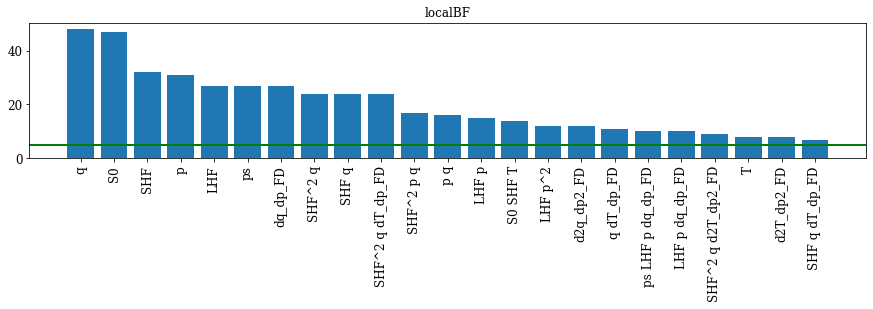

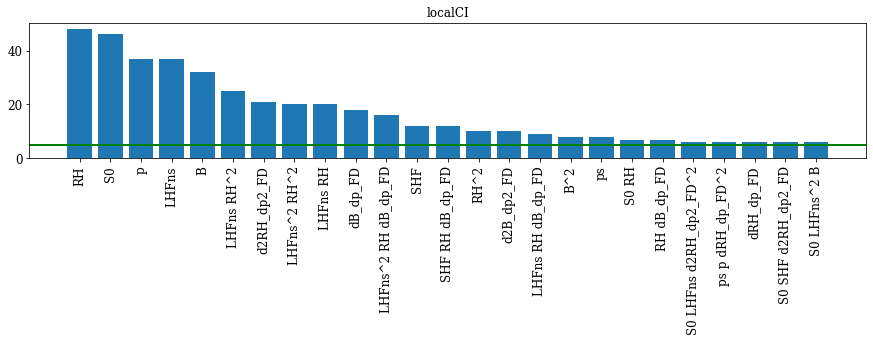

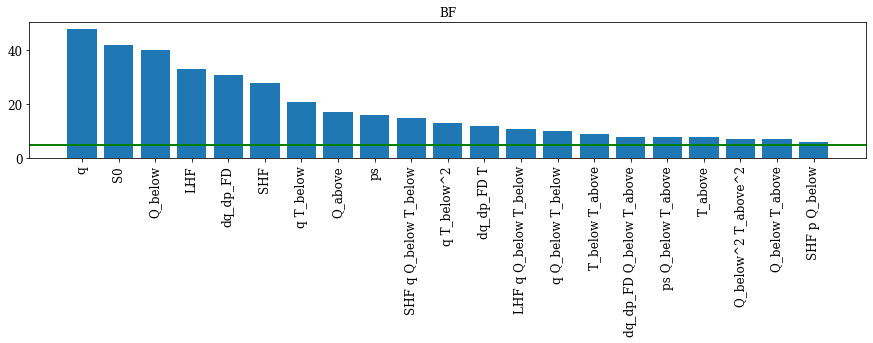

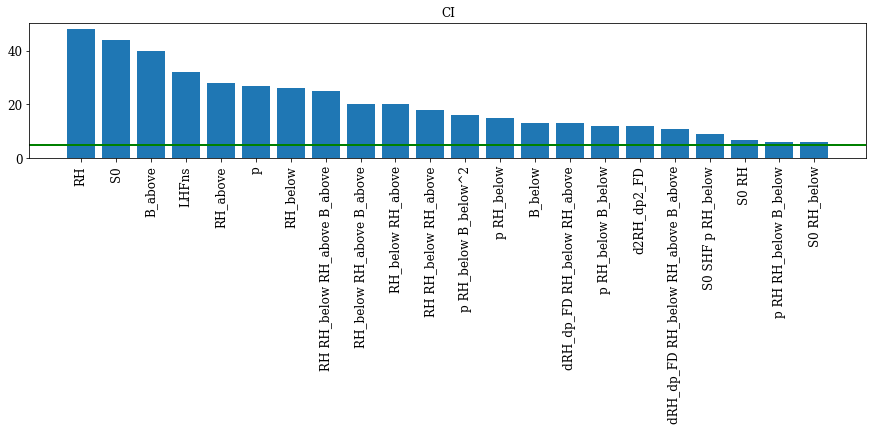

In [19]:
term = termT

for i in range(4):
    fig, ax = plt.subplots(1,1,figsize=(15,2.5))
    plt.bar(term[Models[i]]['variables'][term[Models[i]]['count']>5],
              term[Models[i]]['count'][term[Models[i]]['count']>5])
    plt.axhline(y=5,color='g')
    plt.xticks(rotation=90);
    plt.xticks(fontsize=fz);
    plt.title(Models[i],fontsize=fz)

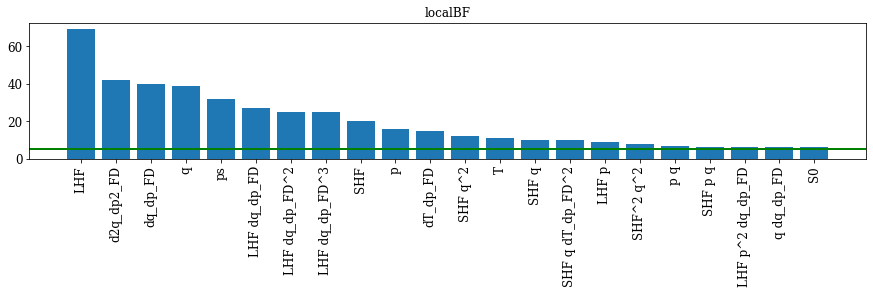

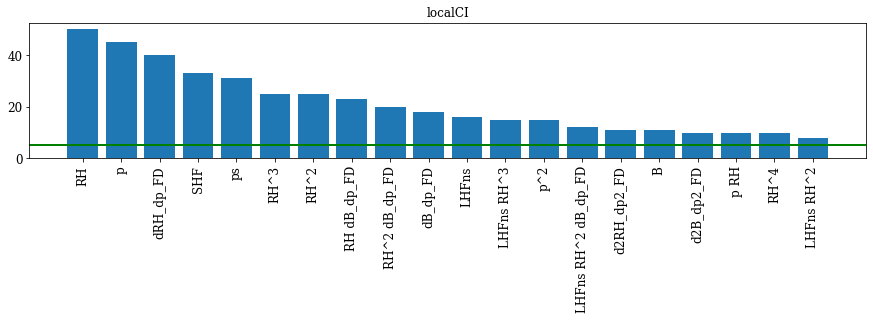

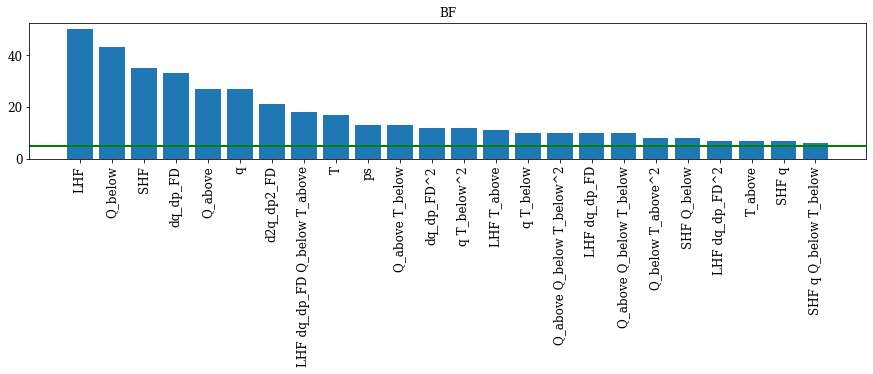

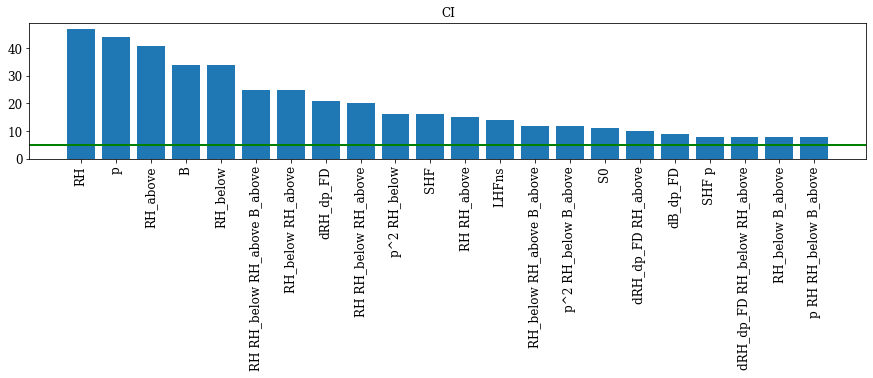

In [20]:
term = termQ

for i in range(4):
    fig, ax = plt.subplots(1,1,figsize=(15,2.5))
    plt.bar(term[Models[i]]['variables'][term[Models[i]]['count']>5],
              term[Models[i]]['count'][term[Models[i]]['count']>5])
    plt.axhline(y=5,color='g')
    plt.xticks(rotation=90);
    plt.xticks(fontsize=fz);
    plt.title(Models[i],fontsize=fz)

## Train model on larger portion of the dataset using the top selected features

### Prototype: LocalBF for subgrid moistening

In [21]:
model = 'localBF'

In [48]:
#terms = termQ[model]['variables'][termQ[model]['count']>5]
terms = termQ[model]['variables']

In [49]:
terms

array(['LHF', 'd2q_dp2_FD', 'dq_dp_FD', 'q', 'ps', 'LHF dq_dp_FD',
       'LHF dq_dp_FD^2', 'LHF dq_dp_FD^3', 'SHF', 'p', 'dT_dp_FD',
       'SHF q^2', 'T', 'SHF q', 'SHF q dT_dp_FD^2', 'LHF p', 'SHF^2 q^2',
       'p q', 'SHF p q', 'LHF p^2 dq_dp_FD', 'q dq_dp_FD', 'S0',
       'SHF p q d2T_dp2_FD', 'd2T_dp2_FD', 'SHF q dT_dp_FD',
       'SHF q dq_dp_FD^2', '1', 'SHF q^2 dq_dp_FD', 'LHF p q',
       'dq_dp_FD^2', 'SHF q dq_dp_FD', 'LHF p^3', 'LHF p dq_dp_FD^2',
       'LHF q dT_dp_FD', 'LHF p dT_dp_FD^2', 'q dT_dp_FD',
       'LHF d2q_dp2_FD^2', 'SHF p^2 q', 'q dq_dp_FD^2', 'p^2 q',
       'SHF p q dq_dp_FD', 'LHF p T', 'LHF p dq_dp_FD T'], dtype='<U18')

Find "base terms" and "base polynomials" that appear in the selected terms

In [50]:
unique_terms = []; unique_pol = [];
for term in terms:
    for t in term.split():
        po = t.find('^')
        if po>0: unique_terms.append(t[:po])
        else: unique_terms.append(t)
        unique_pol.append(t)
unique_terms = list(set(unique_terms))
unique_pol = list(set(unique_pol))

In [51]:
unique_terms

['d2T_dp2_FD',
 'dq_dp_FD',
 'SHF',
 'LHF',
 'dT_dp_FD',
 'q',
 'ps',
 'd2q_dp2_FD',
 'S0',
 '1',
 'p',
 'T']

Problem in current implementation of FD if a second derivative term appears without its first derivative counterpart

In [52]:
unique_pol # Not used in algorithm's current form

['d2T_dp2_FD',
 'dq_dp_FD',
 'dq_dp_FD^3',
 'SHF',
 'SHF^2',
 'LHF',
 'p^3',
 'dT_dp_FD',
 'p^2',
 'q',
 'ps',
 'd2q_dp2_FD',
 'dq_dp_FD^2',
 'q^2',
 'S0',
 '1',
 'd2q_dp2_FD^2',
 'dT_dp_FD^2',
 'p',
 'T']

In [53]:
Nsample = 3000

In [54]:
dictest = {}

In [55]:
# Pre-process & sub-sample the data
i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                            size=((Nsample,)),replace=False).astype('int')
dictest['Selected_indices'] = i_random;

In [56]:
x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,unique_terms)

In [57]:
scalar_sel = list(set(scalar_keys)&set(unique_terms))
vector_sel = list(set(vector_keys)&set(unique_terms))
combin_sel = np.concatenate((scalar_sel,vector_sel))

Load pre-calculated normalization statistics

In [58]:
save_name = path_data+'2022_07_22_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

In [59]:
tmp = pickle.load(open(save_name,'rb'))

In [60]:
Norm = {}
Norm['mean'] = {}
Norm['min'] = {}
Norm['max'] = {}
Norm['std'] = {}
for keys in combin_keys:
    Norm['mean'][keys] = tmp['MEAN'][keys]
    Norm['min'][keys] = tmp['MIN'][keys]
    Norm['max'][keys] = tmp['MAX'][keys]
    Norm['std'][keys] = tmp['STD'][keys]    

In [61]:
x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_sel,vector_sel,Norm=Norm)

Now add the polynomial terms (note that unique_pol is not used at this point)

In [62]:
pol_to_add = list(set(terms).difference(set(unique_terms)))

In [63]:
for key in pol_to_add:
    x_train_range[key] = x_train_range[unique_terms[0]]**0
    for t in key.split():
        po = t.find('^')
        if po>0: x_train_range[key] *= x_train_range[t[:po]]**int(t[po+1:])
        else: x_train_range[key] *= x_train_range[t]

Transform dictionary into tensor for regression purposes

In [64]:
term0 = list(set(terms).difference('1'))

In [65]:
X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
dic_to_array(term0,x_train_range,y_train,scale_dict)

In [66]:
X_train.shape

(90000, 42)

In [67]:
# Linear regression on polynomial features - dQ/dt & dT/dt
dictest = SFS_poly(term0,X_train,dQdt_train,1,10,3)

{'LHF dq_dp_FD^3': 361.07608827322224, 'LR_Bias': -7.945648380691955, 'mse_train': 1389.2577199929794} 

{'LHF dq_dp_FD^2': -595.926260613365, 'LHF dq_dp_FD^3': 1427.352028756626, 'LR_Bias': -4.702464779998137, 'mse_train': 1383.3073499461973} 

{'LHF dq_dp_FD^2': -1375.2777573184553, 'SHF q dq_dp_FD^2': -525.3589259904845, 'LHF dq_dp_FD^3': 3119.257088615827, 'LR_Bias': -3.8122690673279624, 'mse_train': 1364.138752819301} 

{'LHF dq_dp_FD^2': -2904.76637663801, 'SHF p q dq_dp_FD': 3109.4302395216564, 'SHF q dq_dp_FD^2': -5994.170171894686, 'LHF dq_dp_FD^3': 6302.972944366405, 'LR_Bias': -2.6024478010117806, 'mse_train': 1318.0694041258828} 

{'LHF dq_dp_FD^2': -2941.8182117935335, 'SHF p q dq_dp_FD': 12342.21635998652, 'SHF q dq_dp_FD^2': -13073.47955985692, 'LHF dq_dp_FD^3': 6402.892995667449, 'SHF p^2 q': -2972.507315616729, 'LR_Bias': -2.4434725834534308, 'mse_train': 1310.7331743849306} 

{'q dq_dp_FD^2': 365.87988495773686, 'LHF dq_dp_FD^2': -2949.0230830867044, 'SHF p q dq_dp_FD

### Generalize to all models for both subgrid heating/moistening

In [77]:
Model_array = ['localBF','localCI','BF','CI']
Nsample = 100000
Nterms = 10
Ncv = 3
from datetime import datetime

In [78]:
dictest = {}

In [79]:
for imodel,model in enumerate(Model_array):
    print(imodel,model); startTime = datetime.now(); dictest[model] = {} # Initialization

    termsQ = termQ[model]['variables']; termsT = termT[model]['variables']

    # Find unique terms in retained terms
    unique_terms = []; 
    for term in terms:
        for t in term.split():
            po = t.find('^')
            if po>0: unique_terms.append(t[:po])
            else: unique_terms.append(t)
    unique_terms = list(set(unique_terms))

    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dictest['Selected_indices'] = i_random;
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,unique_terms)

    scalar_sel = list(set(scalar_keys)&set(unique_terms))
    vector_sel = list(set(vector_keys)&set(unique_terms))
    combin_sel = np.concatenate((scalar_sel,vector_sel))
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_sel,vector_sel,Norm=Norm)

    pol_to_add = list(set(terms).difference(set(unique_terms)))

    for key in pol_to_add:
        x_train_range[key] = x_train_range[unique_terms[0]]**0
        for t in key.split():
            po = t.find('^')
            if po>0: x_train_range[key] *= x_train_range[t[:po]]**int(t[po+1:])
            else: x_train_range[key] *= x_train_range[t]

    # Transform dictionary into tensor for regression purposes
    term0 = list(set(terms).difference('1'))
    X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
    dic_to_array(term0,x_train_range,y_train,scale_dict)

    # Linear regression on polynomial features - dQ/dt & dT/dt
    dictest[model]['Q'] = SFS_poly(term0,X_train,dQdt_train,1,Nterms,Ncv)
    dictest[model]['T'] = SFS_poly(term0,X_train,dTdt_train,1,Nterms,Ncv)
    
    # Save dictionary
    # Write dict_combined to pkl file
    save_path = path_data+'Polynomial_Fits/2022_07_30_POLYALL_'+model+'_Nsample_'+str(Nsample)+'.pkl'
    pickle.dump({
      "Q": dictest[model]['Q'],
      "T": dictest[model]['T'],
      'Selected_indices': i_random}, open(save_path,'wb'))
    
    print(datetime.now() - startTime)

0 localBF
{'LHF dq_dp_FD^3': 358.5730510323195, 'LR_Bias': -7.953887321984167, 'mse_train': 1480.8528090070452} 

{'SHF^2 q^2': -438.13798122745965, 'LHF dq_dp_FD^3': 477.36667696430277, 'LR_Bias': -9.559854899534525, 'mse_train': 1473.6733116270177} 

{'LHF dq_dp_FD^2': -1025.1190999298271, 'SHF^2 q^2': -696.9744273886857, 'LHF dq_dp_FD^3': 2382.509311546034, 'LR_Bias': -4.9486287923767085, 'mse_train': 1458.9950540692744} 

{'LHF dq_dp_FD^2': -865.1013524519767, 'SHF^2 q^2': -1627.195145401885, 'LHF dq_dp_FD^3': 1945.6621954872032, 'LHF p q': 228.23898808181914, 'LR_Bias': -3.8450495284302466, 'mse_train': 1450.957640926501} 

{'LHF dq_dp_FD^2': -1188.5198801097088, 'SHF^2 q^2': -1655.6172459204981, 'LHF dq_dp_FD^3': 2771.362512575712, 'LHF p q': 2045.590203035398, 'LHF q dT_dp_FD': -2737.4892531632827, 'LR_Bias': -5.025053706607001, 'mse_train': 1412.9673467888917} 

{'LHF dq_dp_FD^2': -1621.3334831818102, 'SHF^2 q^2': -967.341972412052, 'SHF q dq_dp_FD^2': -742.0705676584594, 'LHF 

{'LHF p dq_dp_FD^2': 614.3569737354183, 'LHF p^3': 315.1966258141927, 'SHF p q': -18591.033104906335, 'q': -2110.404037101043, 'S0': 8.17401354878277, 'p q': 2205.0359853349696, 'SHF p^2 q': 5093.085939159179, 'SHF q dT_dp_FD^2': 34779.952013045455, 'LHF p dq_dp_FD T': -1180.6477243679742, 'LR_Bias': -2.639495552495366, 'mse_train': 555.4461079908211} 

1:03:22.648744
2 BF
{'LHF dq_dp_FD^3': 358.54237133191356, 'LR_Bias': -7.923643328161888, 'mse_train': 1448.953409167682} 

{'SHF^2 q^2': -418.74759458620997, 'LHF dq_dp_FD^3': 472.1355415038803, 'LR_Bias': -9.461116237018222, 'mse_train': 1442.4581951643283} 

{'LHF dq_dp_FD^2': -993.7878836871789, 'SHF^2 q^2': -671.0237991154203, 'LHF dq_dp_FD^3': 2318.2083710968063, 'LR_Bias': -4.98013915745003, 'mse_train': 1428.5753142828476} 

{'LHF dq_dp_FD^2': -833.2919252643726, 'SHF^2 q^2': -1639.3736188848852, 'LHF dq_dp_FD^3': 1875.215726057122, 'LHF p q': 236.62752295104374, 'LR_Bias': -3.8085450623270205, 'mse_train': 1419.9148841109534} 


{'LHF p T': -397.9934515221182, 'LHF p dq_dp_FD^2': -118.71266534814167, 'LHF p^3': 346.3423427129411, 'SHF p q': -20240.607804685536, 'q': -2390.3530855901795, 'p q': 2514.927191284693, 'SHF p^2 q': 5236.896662966667, 'SHF q dT_dp_FD^2': 38203.84462250231, 'LR_Bias': 1.7831748161674477, 'mse_train': 579.1578802417963} 

{'LHF p T': -408.2530356327221, 'LHF p dq_dp_FD^2': -104.81790830969626, 'LHF p^3': 353.35662586843824, 'SHF p q': -20239.434807357396, 'q': -2411.8693653210607, 'S0': 7.856575135013585, 'p q': 2534.587173228766, 'SHF p^2 q': 5184.559717477079, 'SHF q dT_dp_FD^2': 38340.01855881816, 'LR_Bias': 0.026690918351365445, 'mse_train': 573.6216377786683} 

0:54:32.207852


## Try out polynomials of polynomials

### Up to degree 2 (all terms)

In [87]:
Model_Types = ['localBF','localCI','BF','CI']
N_subsample = 1
N_degree = 4
min_features = [1,1,1,1,1]
max_features = [5,5,5,5,5]
cv = [2,2,2,2,2]
Nsample = 3000

In [88]:
dict_Q = {}; dict_T = {};

In [89]:
for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};

        termsQ = termQ[model]['variables']; termsT = termT[model]['variables']

        # Find unique terms in retained terms
        unique_terms = []; 
        for term in terms:
            for t in term.split():
                po = t.find('^')
                if po>0: unique_terms.append(t[:po])
                else: unique_terms.append(t)
        unique_terms = list(set(unique_terms))

        # Pre-process & sub-sample the data
        i_random = np.random.choice(np.linspace(0,x.shape[0]-1,x.shape[0]),
                                    size=((Nsample,)),replace=False).astype('int')
        dict_Q[i_subsample]['Selected_indices'] = i_random;
        dict_T[i_subsample]['Selected_indices'] = i_random;

        x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=unique_terms)

        scalar_sel = list(set(scalar_keys)&set(unique_terms))
        vector_sel = list(set(vector_keys)&set(unique_terms))
        combin_sel = np.concatenate((scalar_sel,vector_sel))

        x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_sel,vector_sel)

        pol_to_add = list(set(terms).difference(set(unique_terms)))

        for key in pol_to_add:
            x_train_range[key] = x_train_range[unique_terms[0]]**0
            for t in key.split():
                po = t.find('^')
                if po>0: x_train_range[key] *= x_train_range[t[:po]]**int(t[po+1:])
                else: x_train_range[key] *= x_train_range[t]
    
        # Transform dictionary into array for regression purposes
        term0 = list(set(terms).difference('1'))
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(term0,x_train_range,y_train,scale_dict)
    
        for degree in np.arange(2,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(term0)) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_30_deg2NL_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))

i_subsample=0/0
model_type=localBF
degree=2
{'LHF p dq_dp_FD^2 LHF dq_dp_FD^3': 621.0005513270448, 'LR_Bias': -2.644793329486121, 'mse_train': 1402.9192691786302} 

{'SHF SHF q dT_dp_FD^2': -1002.5878835880342, 'LHF p dq_dp_FD^2 LHF dq_dp_FD^3': 1282.504130792302, 'LR_Bias': -1.573177848806257, 'mse_train': 1375.7303951825966} 

{'SHF SHF p q': 5593.672638848636, 'SHF SHF q dT_dp_FD^2': -10571.0497240662, 'LHF p dq_dp_FD^2 LHF dq_dp_FD^3': 1374.4616777863112, 'LR_Bias': -0.30329380930327676, 'mse_train': 1322.0795358367766} 

{'SHF SHF p q': 34899.85929187932, 'SHF SHF p^2 q': -18093.350447144643, 'SHF SHF q dT_dp_FD^2': -32663.125056713165, 'LHF p dq_dp_FD^2 LHF dq_dp_FD^3': 1446.9148416510966, 'LR_Bias': 0.1613766073645878, 'mse_train': 1294.234181995583} 

{'SHF SHF q dT_dp_FD^2': 404.91543668807947, 'LR_Bias': -1.7125301500604677, 'mse_train': 672.8596678278202} 

{'SHF SHF p q': -4430.173832410663, 'SHF SHF q dT_dp_FD^2': 7922.537863960285, 'LR_Bias': -2.775660417897105, 'mse_trai

MemoryError: Unable to allocate 109. GiB for an array with shape (90000, 163185) and data type float64

### Up to degree 4 (top terms)

# Fit-the-CDF method

## Calculate the empirical CDF of the main variables

In [ ]:
x.shape

In [ ]:
Nsample = 2500000

In [ ]:
i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')

In [ ]:
x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])

In [ ]:
combin_keys = np.concatenate((scalar_keys,vector_keys))

In [ ]:
def edg2bin(edges):
    return (edges[:-1]+edges[1:])/2

In [ ]:
PDF = {}; EDG = {}; CDF = {}; MAX = {}; MIN = {};

In [ ]:
PDF = {}; EDG = {}; CDF = {}; MAX = {}; MIN = {}; MEAN = {}; STD = {}

In [ ]:
for k in x_train.keys():
    print(k)
    PDF[k],EDG[k] = np.histogram(x_train[k].flatten(),bins=250,density=True)
    db = np.array(np.diff(EDG[k]), float)  
    CDF[k] = db*PDF[k].cumsum()
    MAX[k] = np.max(x_train[k].flatten())
    MIN[k] = np.min(x_train[k].flatten())
    MEAN[k] = np.mean(x_train[k].flatten())
    STD[k] = np.std(x_train[k].flatten())

Save the CDFs to fit them in an independent notebook

In [ ]:
save_name = path_data+'2022_07_22_NORM_PDF_CDF_TRAIN_BOTH_M4K_P4K'

In [ ]:
#pickle.dump({"PDF":PDF,"CDF":CDF,"EDG":EDG,"MAX":MAX,"MIN":MIN,"MEAN":MEAN,"STD":STD}, open(save_name,'wb'))

In [ ]:
plt.plot(edg2bin(EDG['T_above']),CDF['T_above'])

In [ ]:
cumtrapz(x=edg2bin(EDG['T']),y=PDF['T'],initial=0).shape

In [ ]:
def cdf_q(x):
    
    from scipy.special import erf
    
    def acosh_abs(x):
        return np.arccosh(np.abs(x)+1e-8+1)
    
    return erf(np.arctan(np.tanh(acosh_abs(x) * 8.828)))

In [ ]:
def cdf_dqdt(x):
    
    def relu(x):
        return x*(x>0)
    
    return (relu(x -2*6.0664007e-9) / np.maximum(x,1e-10))

In [ ]:
test = cdf_q(x_train['q'])

In [ ]:
test2 = cdf_dqdt(x_train['dq_dp_FD'])

## Include the CDF transform as optional variables when sub-sampling

In [ ]:
def CDF_keys(x0,key):
    
    from scipy.special import erfc
    from scipy.special import gamma
    from scipy.special import erf
    
    def relu(x):
        return x*(x>0)

    def log10_abs(x):
        return np.log10(np.abs(x)+1e-8)

    def cos(x):
        return np.cos(x)

    def acosh_abs(x):
        return np.arccosh(np.abs(x)+1e-8+1)

    def asinh(x):
        return np.arcsinh(x)

    def cube(x):
        return x**3

    def square(x):
        return x**2

    def tanh(x):
        return np.tanh(x)

    def tan(x):
        return np.tan(x)

    def sin(x):
        return np.sin(x)

    def sinh(x):
        return np.sinh(x)

    def exp(x):
        return np.exp(x)

    def atan(x):
        return np.arctan(x)
    
    if key=='p': cdf = atan((x0 * 1e-5) + 0.15) # Retained third candidate
    elif key=='q': cdf = erf(atan(tanh(acosh_abs(x0) * 8.828))) # Retained last candidate
    elif key=='T': cdf = ((sinh(log10_abs(x0))-4.6766) * 0.813) # Retained last candidate that didn't ReLU neg T
    elif key=='RH': cdf = cos((x0*0.7456)-1.45) # Keeps monotonically increasing property of CDF
    elif key=='B': cdf = (atan(exp(x0 / acosh_abs(x0)))-0.0214) # Has the best CDF properties
    elif key=='S0': cdf = erf(x0* 0.000438 + 0.212) # Pretty "easy" CDF
    elif key=='ps': cdf = erf(cube(tan(x0 * 1e-4))) # Has better monotonicity properties, but not valid at high ps
    elif key=='SHF': cdf = relu(tanh((x0 + 1.965) * 0.05))
    elif key=='LHF': cdf = tanh(relu((x0 + 13.2) * 0.0096))
    elif key=='LHFns': cdf = square(erfc(erfc(asinh((x0 / 0.011873) + 0.023746))))
        
    return np.maximum(0,np.minimum(1,cdf))

In [ ]:
Model_Types = ['localBF_CDF','BF_CDF','localBF','localCI_CDF','CI_CDF','localCI']
N_subsample = 5
N_degree = 3
Nsample = 3000

KEYS = {}
KEYS['local'] = ['ps', 'S0', 'SHF', 'LHF','LHFns','p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localCI'] = ['ps', 'S0', 'SHF','LHFns','p','RH', 'dRH_dp_FD',
              'd2RH_dp2_FD','B', 'dB_dp_FD','d2B_dp2_FD']
KEYS['localBF'] = ['ps', 'S0', 'SHF', 'LHF', 'p', 'q', 'dq_dp_FD',
              'd2q_dp2_FD','T', 'dT_dp_FD','d2T_dp2_FD']
KEYS['all'] = np.concatenate((KEYS['local'],['Q_above','Q_below','T_below','T_above',
                                             'RH_below','RH_above','B_below','B_above']))
KEYS['BF'] = np.concatenate((KEYS['localBF'],['Q_above','Q_below','T_below','T_above']))
KEYS['CI'] = np.concatenate((KEYS['localCI'],['RH_below','RH_above','B_below','B_above']))
scalar_keys = ['ps','S0','SHF','LHF','LHFns']
vector_keys = ['p', 'q', 'dq_dp_FD', 'd2q_dp2_FD', 'Q_above', 'Q_below',
               'T', 'dT_dp_FD', 'd2T_dp2_FD', 'T_above', 'T_below',
               'RH', 'dRH_dp_FD', 'd2RH_dp2_FD', 'RH_above', 'RH_below',
               'B', 'dB_dp_FD', 'd2B_dp2_FD', 'B_above', 'B_below']
combin_keys = np.concatenate((scalar_keys,vector_keys))
KEYS['CDF_vector'] = ['p','q','T','RH','B']
KEYS['CDF_scalar'] = ['S0','ps','SHF','LHF','LHFns']
KEYS['CDF'] = np.concatenate((KEYS['CDF_vector'],KEYS['CDF_scalar']))
for k in KEYS['CDF_scalar']:
    scalar_keys = np.concatenate((scalar_keys,['CDF_'+k]))
for k in KEYS['CDF_vector']:
    vector_keys = np.concatenate((vector_keys,['CDF_'+k,'dCDF_'+k+'dp_FD','d2CDF_'+k+'dp2_FD']))
combin_keys = np.concatenate((scalar_keys,vector_keys))
KEYS['BF_CDF'] = ['CDF_S0', 'CDF_ps', 'CDF_SHF', 'CDF_LHF','CDF_p','CDF_q', 'dCDF_qdp_FD',
                  'd2CDF_qdp2_FD', 'CDF_T', 'dCDF_Tdp_FD','d2CDF_Tdp2_FD']
KEYS['localBF_CDF'] = np.concatenate((KEYS['localBF'],KEYS['BF_CDF']))
KEYS['CI_CDF'] = ['CDF_S0', 'CDF_ps', 'CDF_SHF', 'CDF_LHFns',
                  'CDF_p','CDF_RH','dCDF_RHdp_FD', 'd2CDF_RHdp2_FD',
                  'CDF_B', 'dCDF_Bdp_FD','d2CDF_Bdp2_FD']
KEYS['localCI_CDF'] = np.concatenate((KEYS['localCI'],KEYS['CI_CDF']))

min_features = [1,1,1,1,1]
max_features = [11,6,6,6,6]
cv = [2,2,2,2,2]

dict_Q = {}; dict_T = {};

In [ ]:
## Second attempt, this time using both the cold and the warm parts of the dataset

for i_subsample in range(N_subsample):
    print('i_subsample='+str(i_subsample)+'/'+str(N_subsample-1))
    dict_Q[i_subsample] = {}; dict_T[i_subsample] = {};
    
    # Pre-process & sub-sample the data
    i_random = np.random.choice(np.linspace(0,xt[clim].shape[0]-1,xt[clim].shape[0]),
                                size=((Nsample,)),replace=False).astype('int')
    dict_Q[i_subsample]['Selected_indices'] = i_random;
    dict_T[i_subsample]['Selected_indices'] = i_random;
    
    x_train,x_test,y_train,y_test = subsampler(i_random,x,y,xRH,xB,xLHFns,hyam,hybm,variables=KEYS['all'])
    for k in KEYS['CDF']:
        x_train['CDF_'+k] = CDF_keys(x_train[k],k)
        if k in KEYS['CDF_vector']:
            x_train['dCDF_'+k+'dp_FD'] = p_derivative(x_train['CDF_'+k],x_train['p'])
            x_train['d2CDF_'+k+'dp2_FD'] = p_derivative(x_train['dCDF_'+k+'dp_FD'],x_train['p'])
    x_train_range,x_test_range,Norm = range_normalizer(x_train,scalar_keys,vector_keys)
    
    for model_type in (Model_Types):
        print('model_type='+model_type)
        dict_Q[i_subsample][model_type] = {}; dict_T[i_subsample][model_type] = {};
        
        # Transform dictionary into array for regression purposes
        X_train,X_test,dQdt_train,dQdt_test,dTdt_train,dTdt_test = \
        dic_to_array(KEYS[model_type],x_train_range,y_train,scale_dict)
    
        for degree in np.arange(1,N_degree+1):
            print('degree='+str(degree))
            dic_to_save = {}; ideg = degree-1;
            
            # Polynomial features
            poly = PolynomialFeatures(degree=degree)
            X_train_poly = poly.fit_transform(X_train)    
            features = poly.get_feature_names(np.array(KEYS[model_type])) # Update the feature names
                
            # Linear regression on polynomial features - dQ/dt & dT/dt
            dict_Q[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dQdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
            dict_T[i_subsample][model_type][degree] = \
            SFS_poly(features,X_train_poly,dTdt_train,
                     min_features[ideg],max_features[ideg],cv[ideg])
            
        # Write dict_combined to pkl file
        save_path = path_data+'Polynomial_Fits/2022_07_19_dicCDF_'+model_type+'_isample_'+str(i_subsample+1)+'.pkl'
        pickle.dump({
          "Qfits": dict_Q[i_subsample][model_type],
          "Tfits": dict_T[i_subsample][model_type],
          'Selected_indices': i_random}, open(save_path,'wb'))
